# Finetuning a Language Model to Predict Static Rankings

In this notebook, we'll attempt to finetune a pre-trained language model in the task of static ranking prediction.
We'll use the CORD-19 dataset compiled by the Allen Institute for Artificial Intelligence, which comprehends more than 200.000 papers related to the Coronavirus pandemic.
This dataset has received wide attention in the data mining and natural language processing community in order to develop tools to aid health workers stay up-to-date with the latest and most relevant research about the current pandemic.

We'll build the references graph and use the PageRank static ranking algorithm to assess the relevance of each paper.
Then, we'll put a classifier head on top of a pre-trained language model and finetune it using the ranking scores as supervision in a semi-supervised way.

## Building the references graph

Refer to the following notebooks to inspect the source code used to build the references graph.

- https://github.com/Inria-Chile/risotto/blob/master/01_references.ipynb
- https://github.com/Inria-Chile/risotto/blob/master/05_cook_artifacts.ipynb

In [ ]:
from google.colab import drive

drive.mount("/drive")

!ls -lart /drive/My\ Drive/RISOTTO/artifacts/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /drive
total 409093
-rw------- 1 root root 200066852 Jul 22 20:56 artifacts.hdf
-rw------- 1 root root 109275992 Aug  5 22:45 artifact.4.hdf
-rw------- 1 root root 109567796 Aug  6 14:55 papers.csv


In [ ]:
!pip install -U pandas tables numpy transformers torch pytorch-lightning wandb tqdm
!wandb login 2aba1e6e822f4d23e1091c2515cb3562cd972f60

Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (1.1.0)
Requirement already up-to-date: tables in /usr/local/lib/python3.6/dist-packages (3.6.1)
Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (1.19.1)
Requirement already up-to-date: transformers in /usr/local/lib/python3.6/dist-packages (3.0.2)
Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.6.0+cu101)
Requirement already up-to-date: pytorch-lightning in /usr/local/lib/python3.6/dist-packages (0.8.5)
Requirement already up-to-date: wandb in /usr/local/lib/python3.6/dist-packages (0.9.4)
     |████████████████████████████████| 71kB 2.0MB/s 
ERROR: pytorch-lightning 0.8.5 has requirement future>=0.17.1, but you'll have future 0.16.0 which is incompatible.
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [ ]:
import pandas as pd
import numpy as np

ARTIFACTS_PATH = "/drive/My Drive/RISOTTO/artifacts/papers.csv"


def get_papers():
    papers = pd.read_csv(ARTIFACTS_PATH).fillna("N/A")
    return papers

papers = get_papers()
display(papers.head())
papers.columns, papers.shape

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,cord_uid,pagerank,affiliation,country,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,0.000000,N/A,N/A,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,1.14726e+07,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,N/A,N/A,N/A,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,N/A
1,02tnwd4m,0.030459,University of Alabama at Birmingham,USA,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,1.1668e+07,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,N/A,N/A,N/A,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,N/A
2,ejv2xln0,0.215860,Washington University School of Medicine,USA,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,1.1668e+07,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,N/A,N/A,N/A,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,N/A
3,2b73a28n,0.043255,N/A,N/A,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,1.16869e+07,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,N/A,N/A,N/A,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,N/A
4,9785vg6d,0.036417,National Institutes of Health (Laboratory of H...,USA,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,1.16869e+07,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,N/A,N/A,N/A,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,N/A


(Index(['cord_uid', 'pagerank', 'affiliation', 'country', 'sha', 'source_x',
        'title', 'doi', 'pmcid', 'pubmed_id', 'license', 'abstract',
        'publish_time', 'authors', 'journal', 'mag_id', 'who_covidence_id',
        'arxiv_id', 'pdf_json_files', 'pmc_json_files', 'url', 's2_id'],
       dtype='object'), (62427, 22))

## Finetuning a pre--trained language model

We'll implement our model using PyTorch.
We'll use available pre-trained language models published in the HuggingFace's models repository.
Finally, we'll use the PyTorch Lightning framework to structure our project..

## Quick EDA

In order to better understand our data, we'll do a quick exploratory data analysis.
Particularly, we are interested in looking at the PageRank values distribution and the cumulative number of papers along the time axis.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


count    62427.000000
mean         0.044230
std          0.089507
min          0.000000
25%          0.000000
50%          0.000000
75%          0.046361
max          1.000000
Name: pagerank, dtype: float64

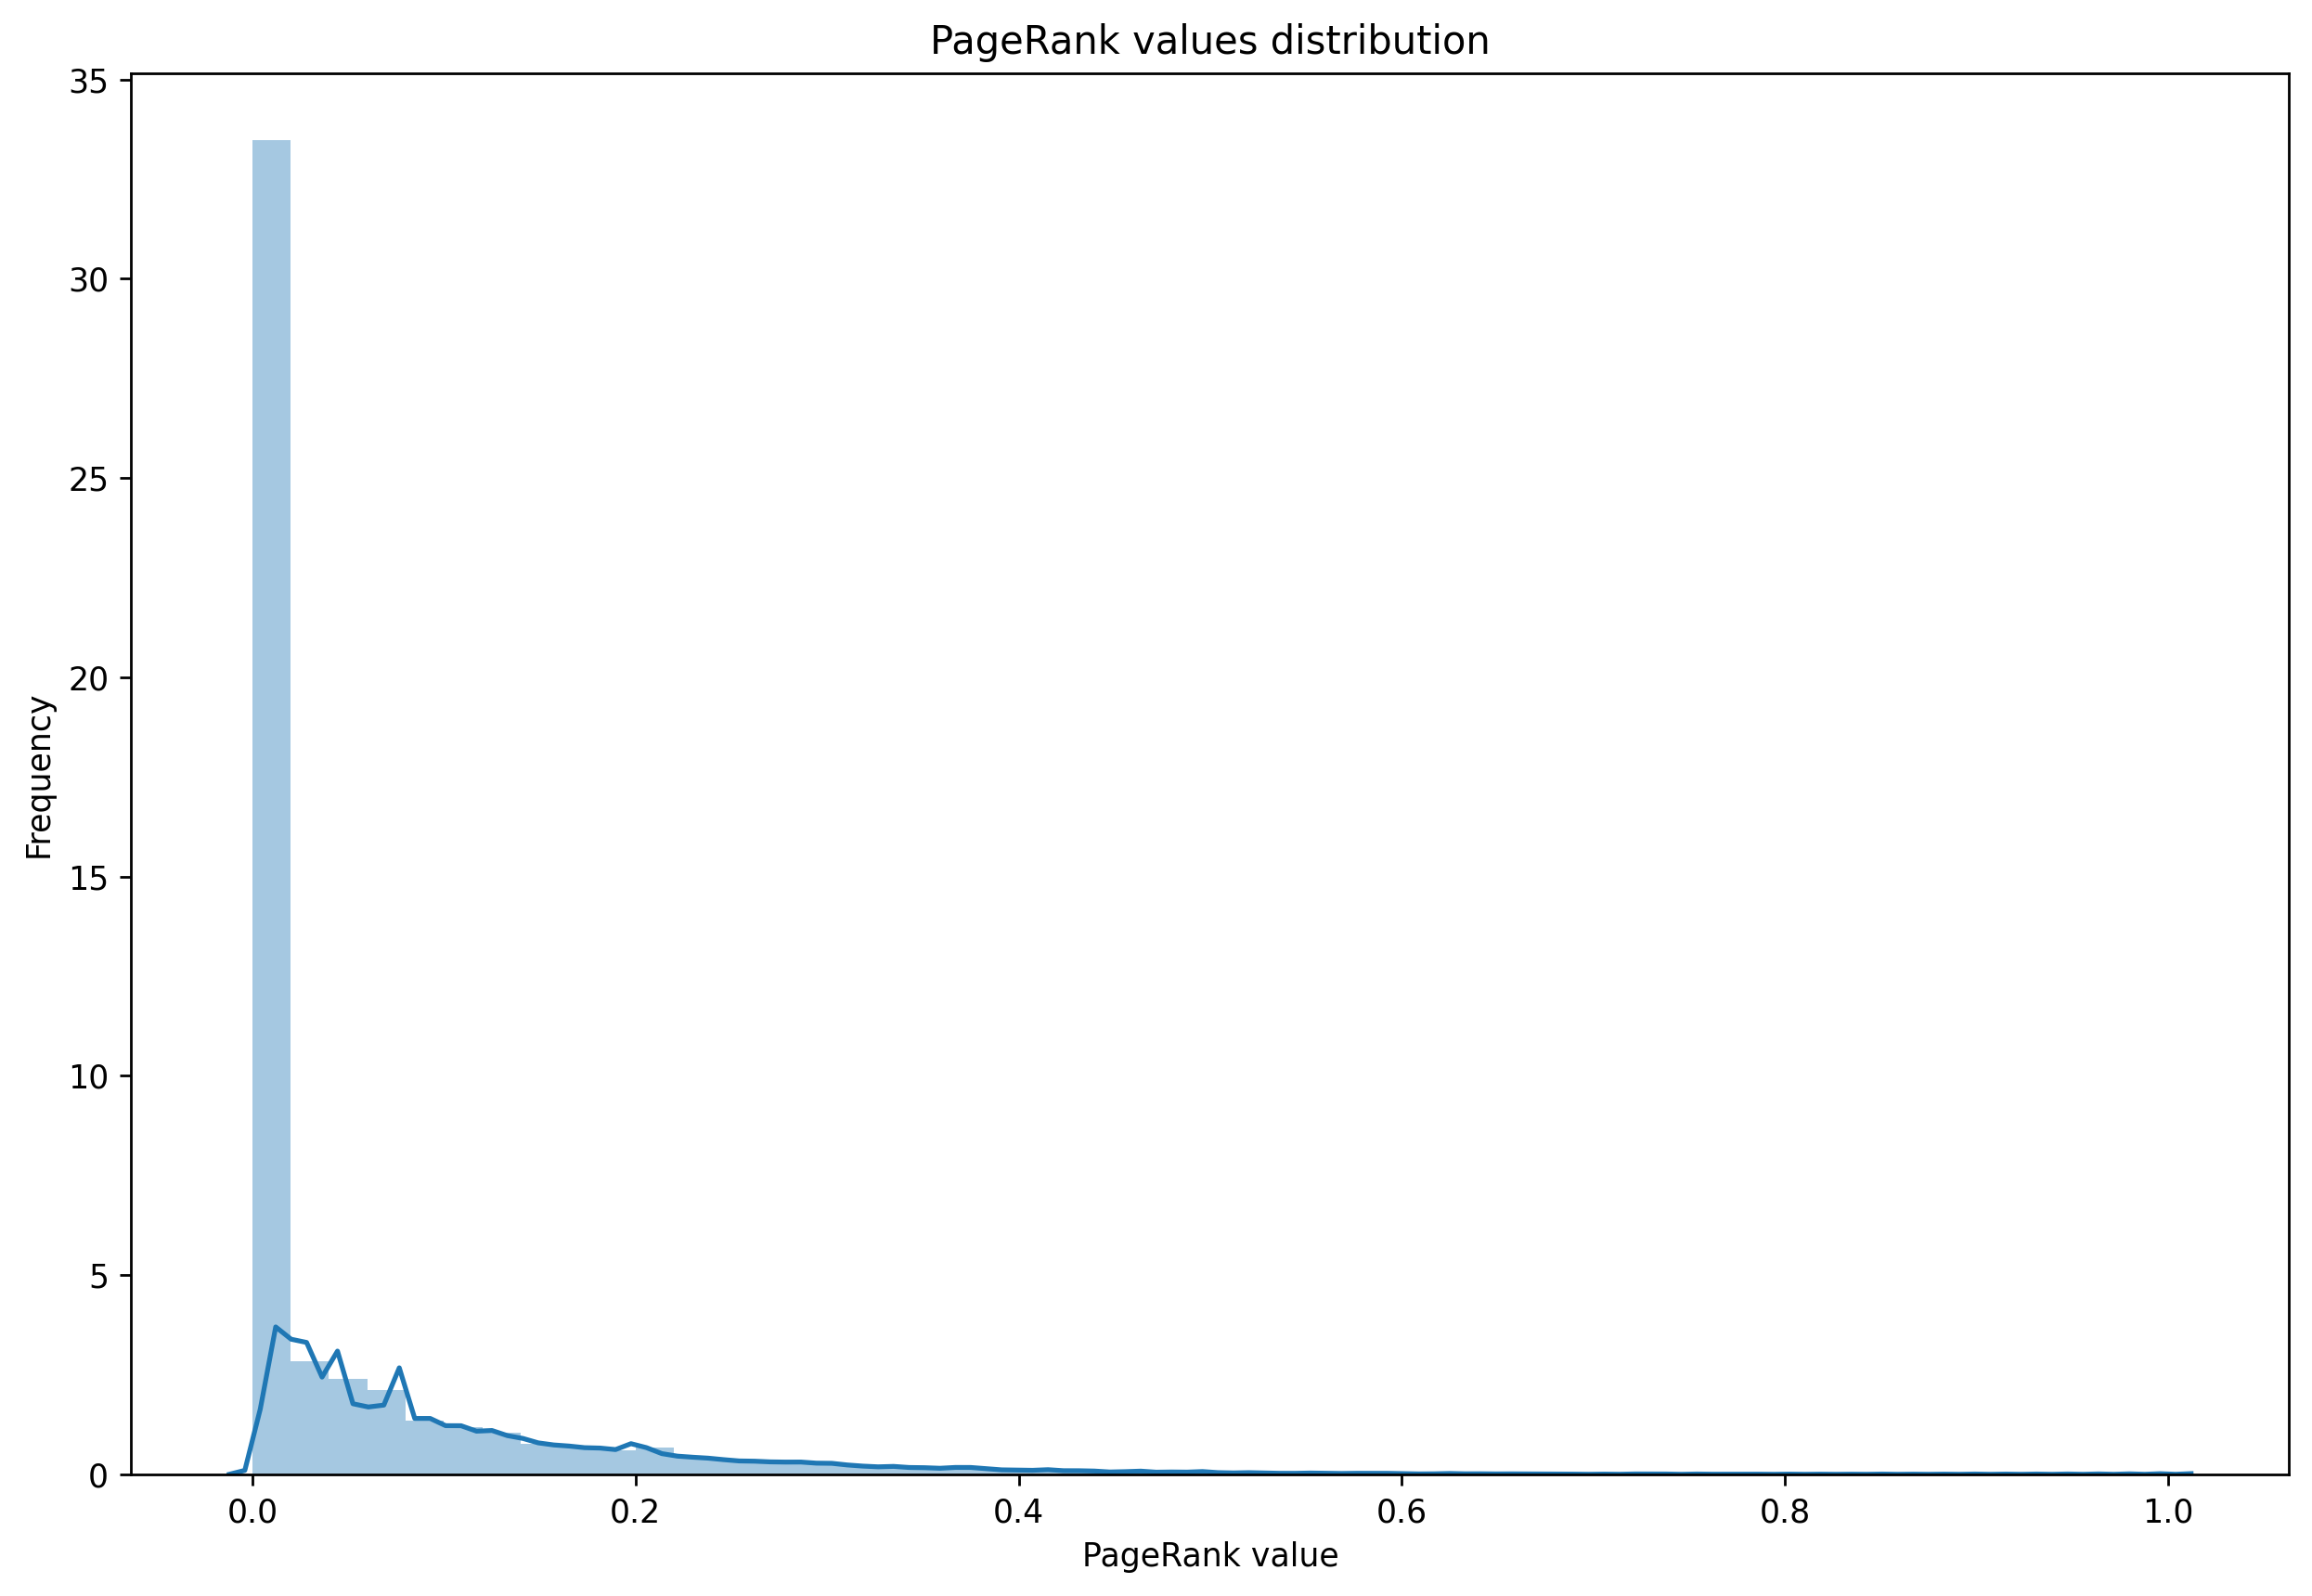

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


display(papers["pagerank"].describe())

fig = plt.figure(figsize=(12, 8), dpi=250)

ax = sns.distplot(papers["pagerank"])
ax.set(
    title="PageRank values distribution",
    xlabel="PageRank value",
    ylabel="Frequency"
)

plt.show()

As expected, the PageRank values distribution is heavily skewed towards zero.

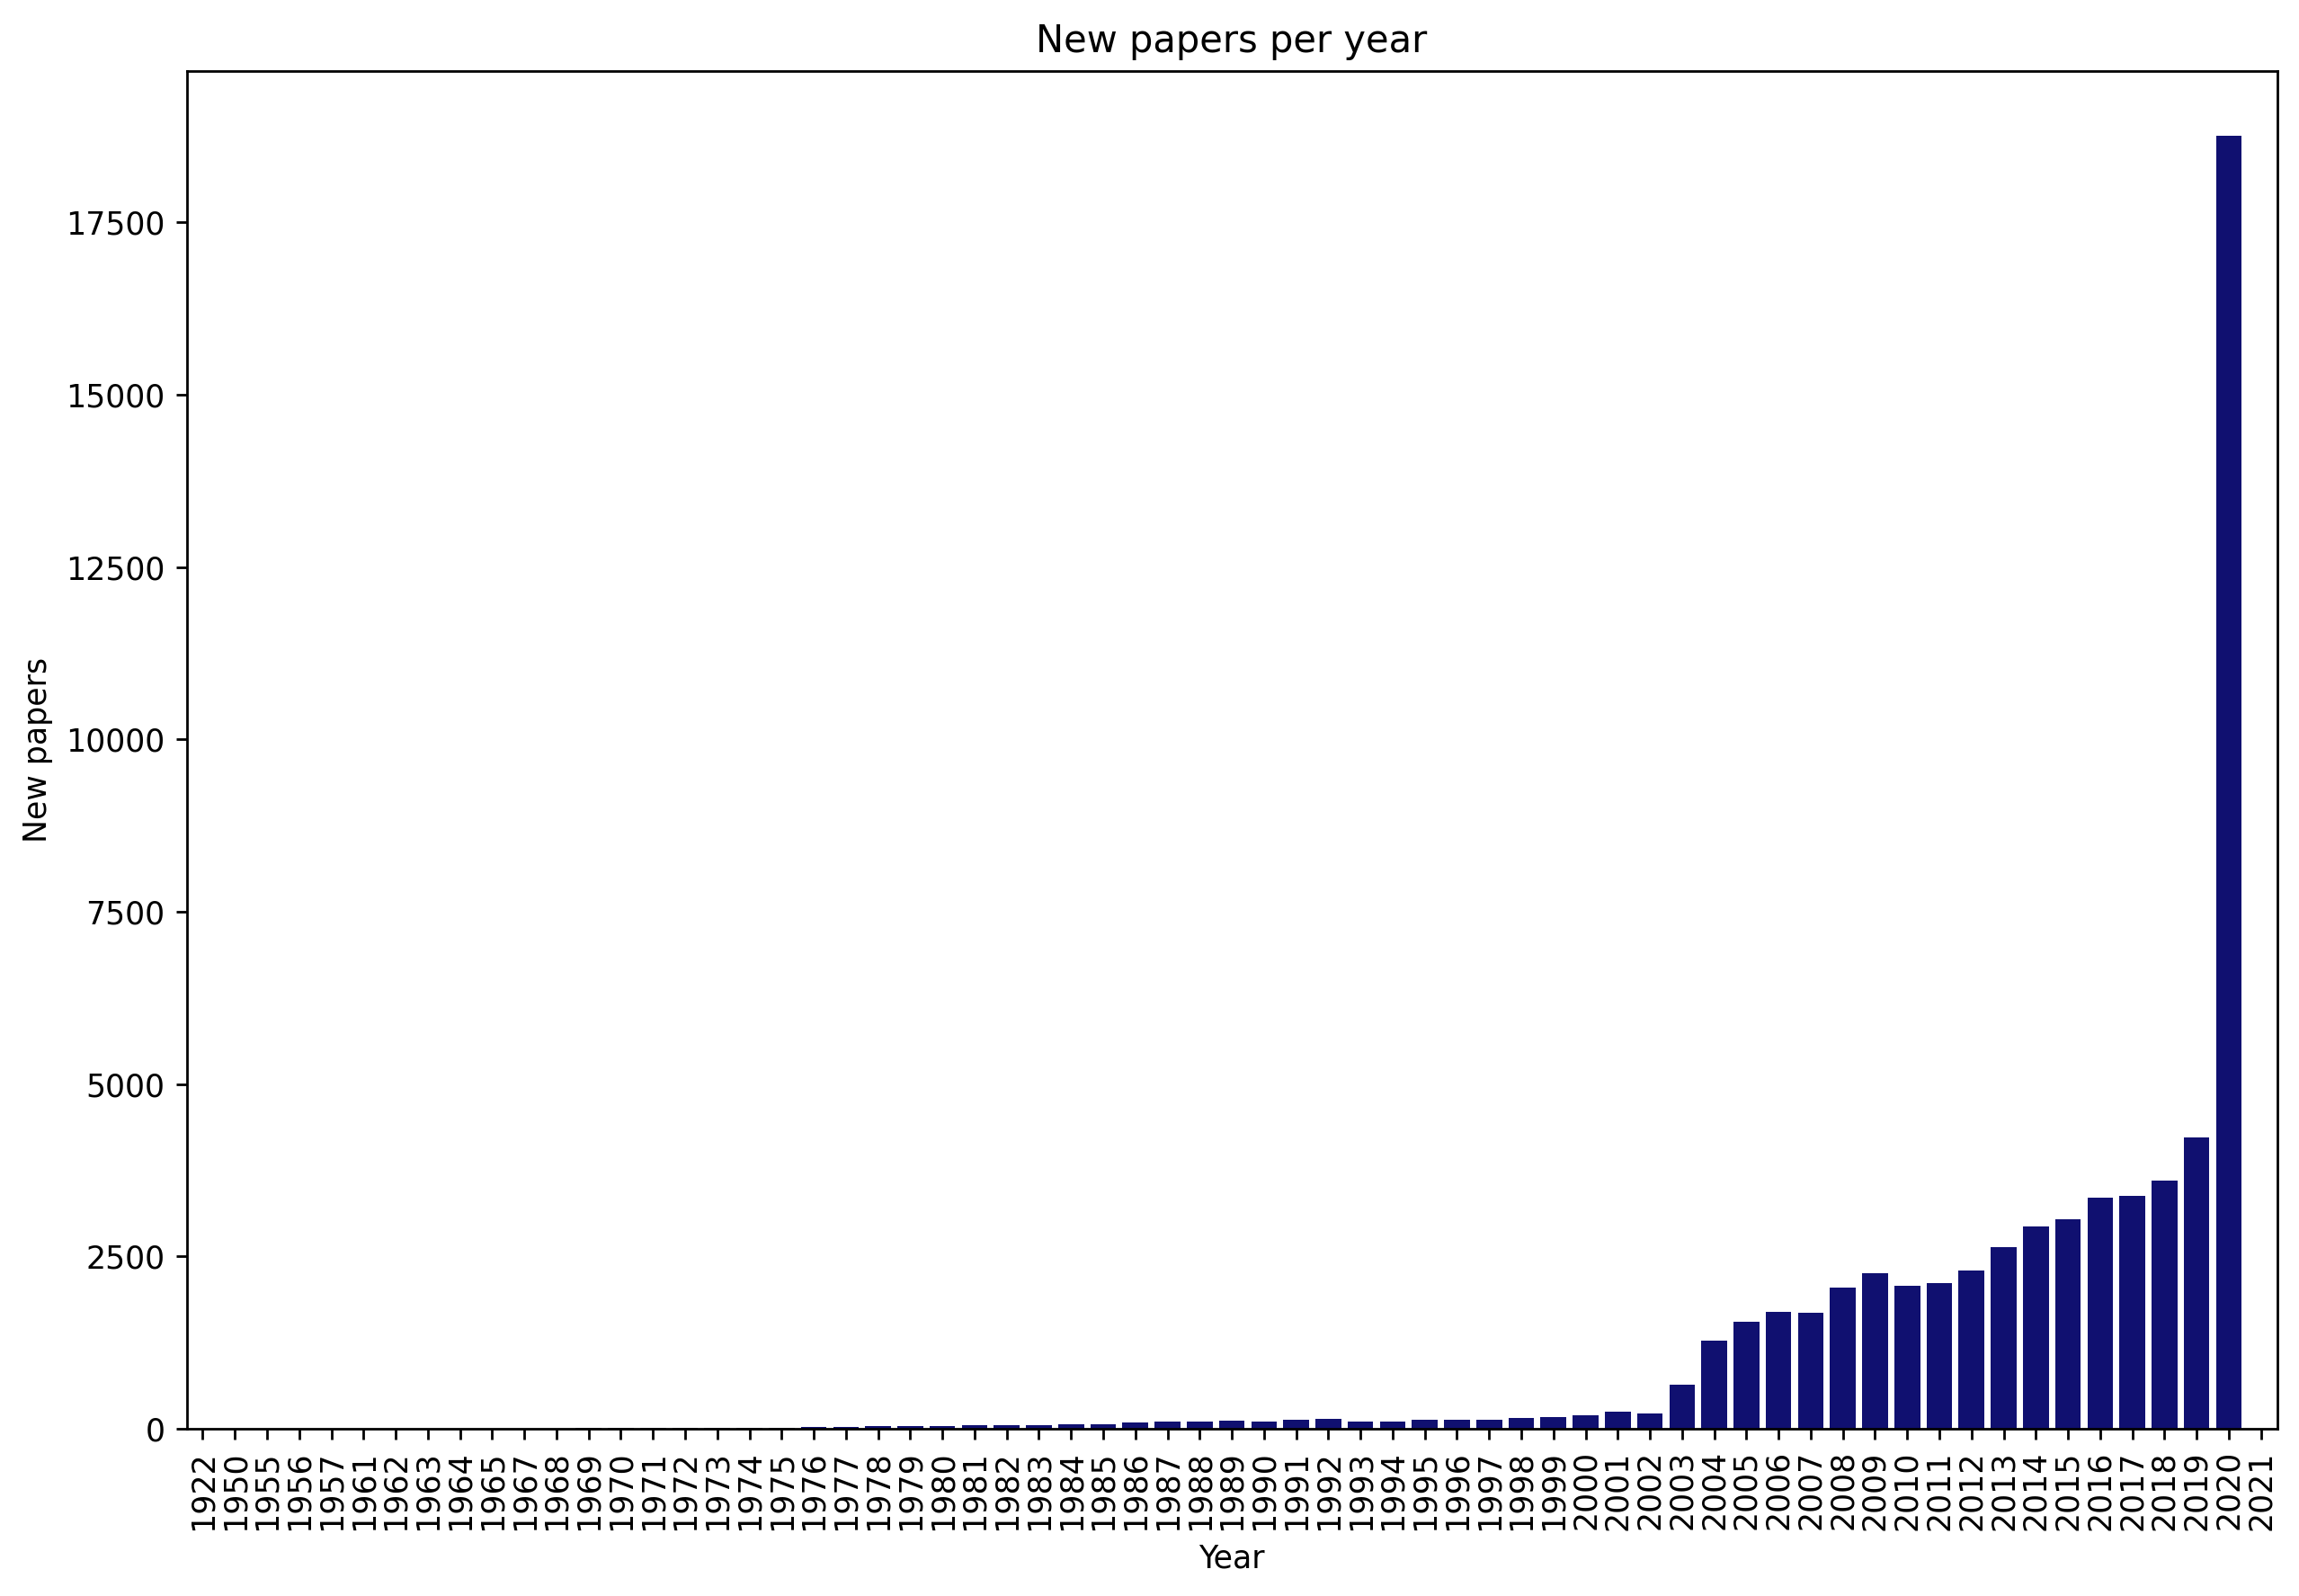

In [ ]:
papers["publish_time"] = pd.to_datetime(papers["publish_time"], errors="coerce")
papers_per_year = papers.groupby(papers["publish_time"].dt.year).size()

fig = plt.figure(figsize=(12, 8), dpi=250)

ax = sns.barplot(x=papers_per_year.index.astype(int), y=papers_per_year, color=(0, 0, 0.5))
ax.set(
    title="New papers per year",
    xlabel="Year",
    ylabel="New papers",
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.show()

As expected, most of the dataset papers were published in recent years.

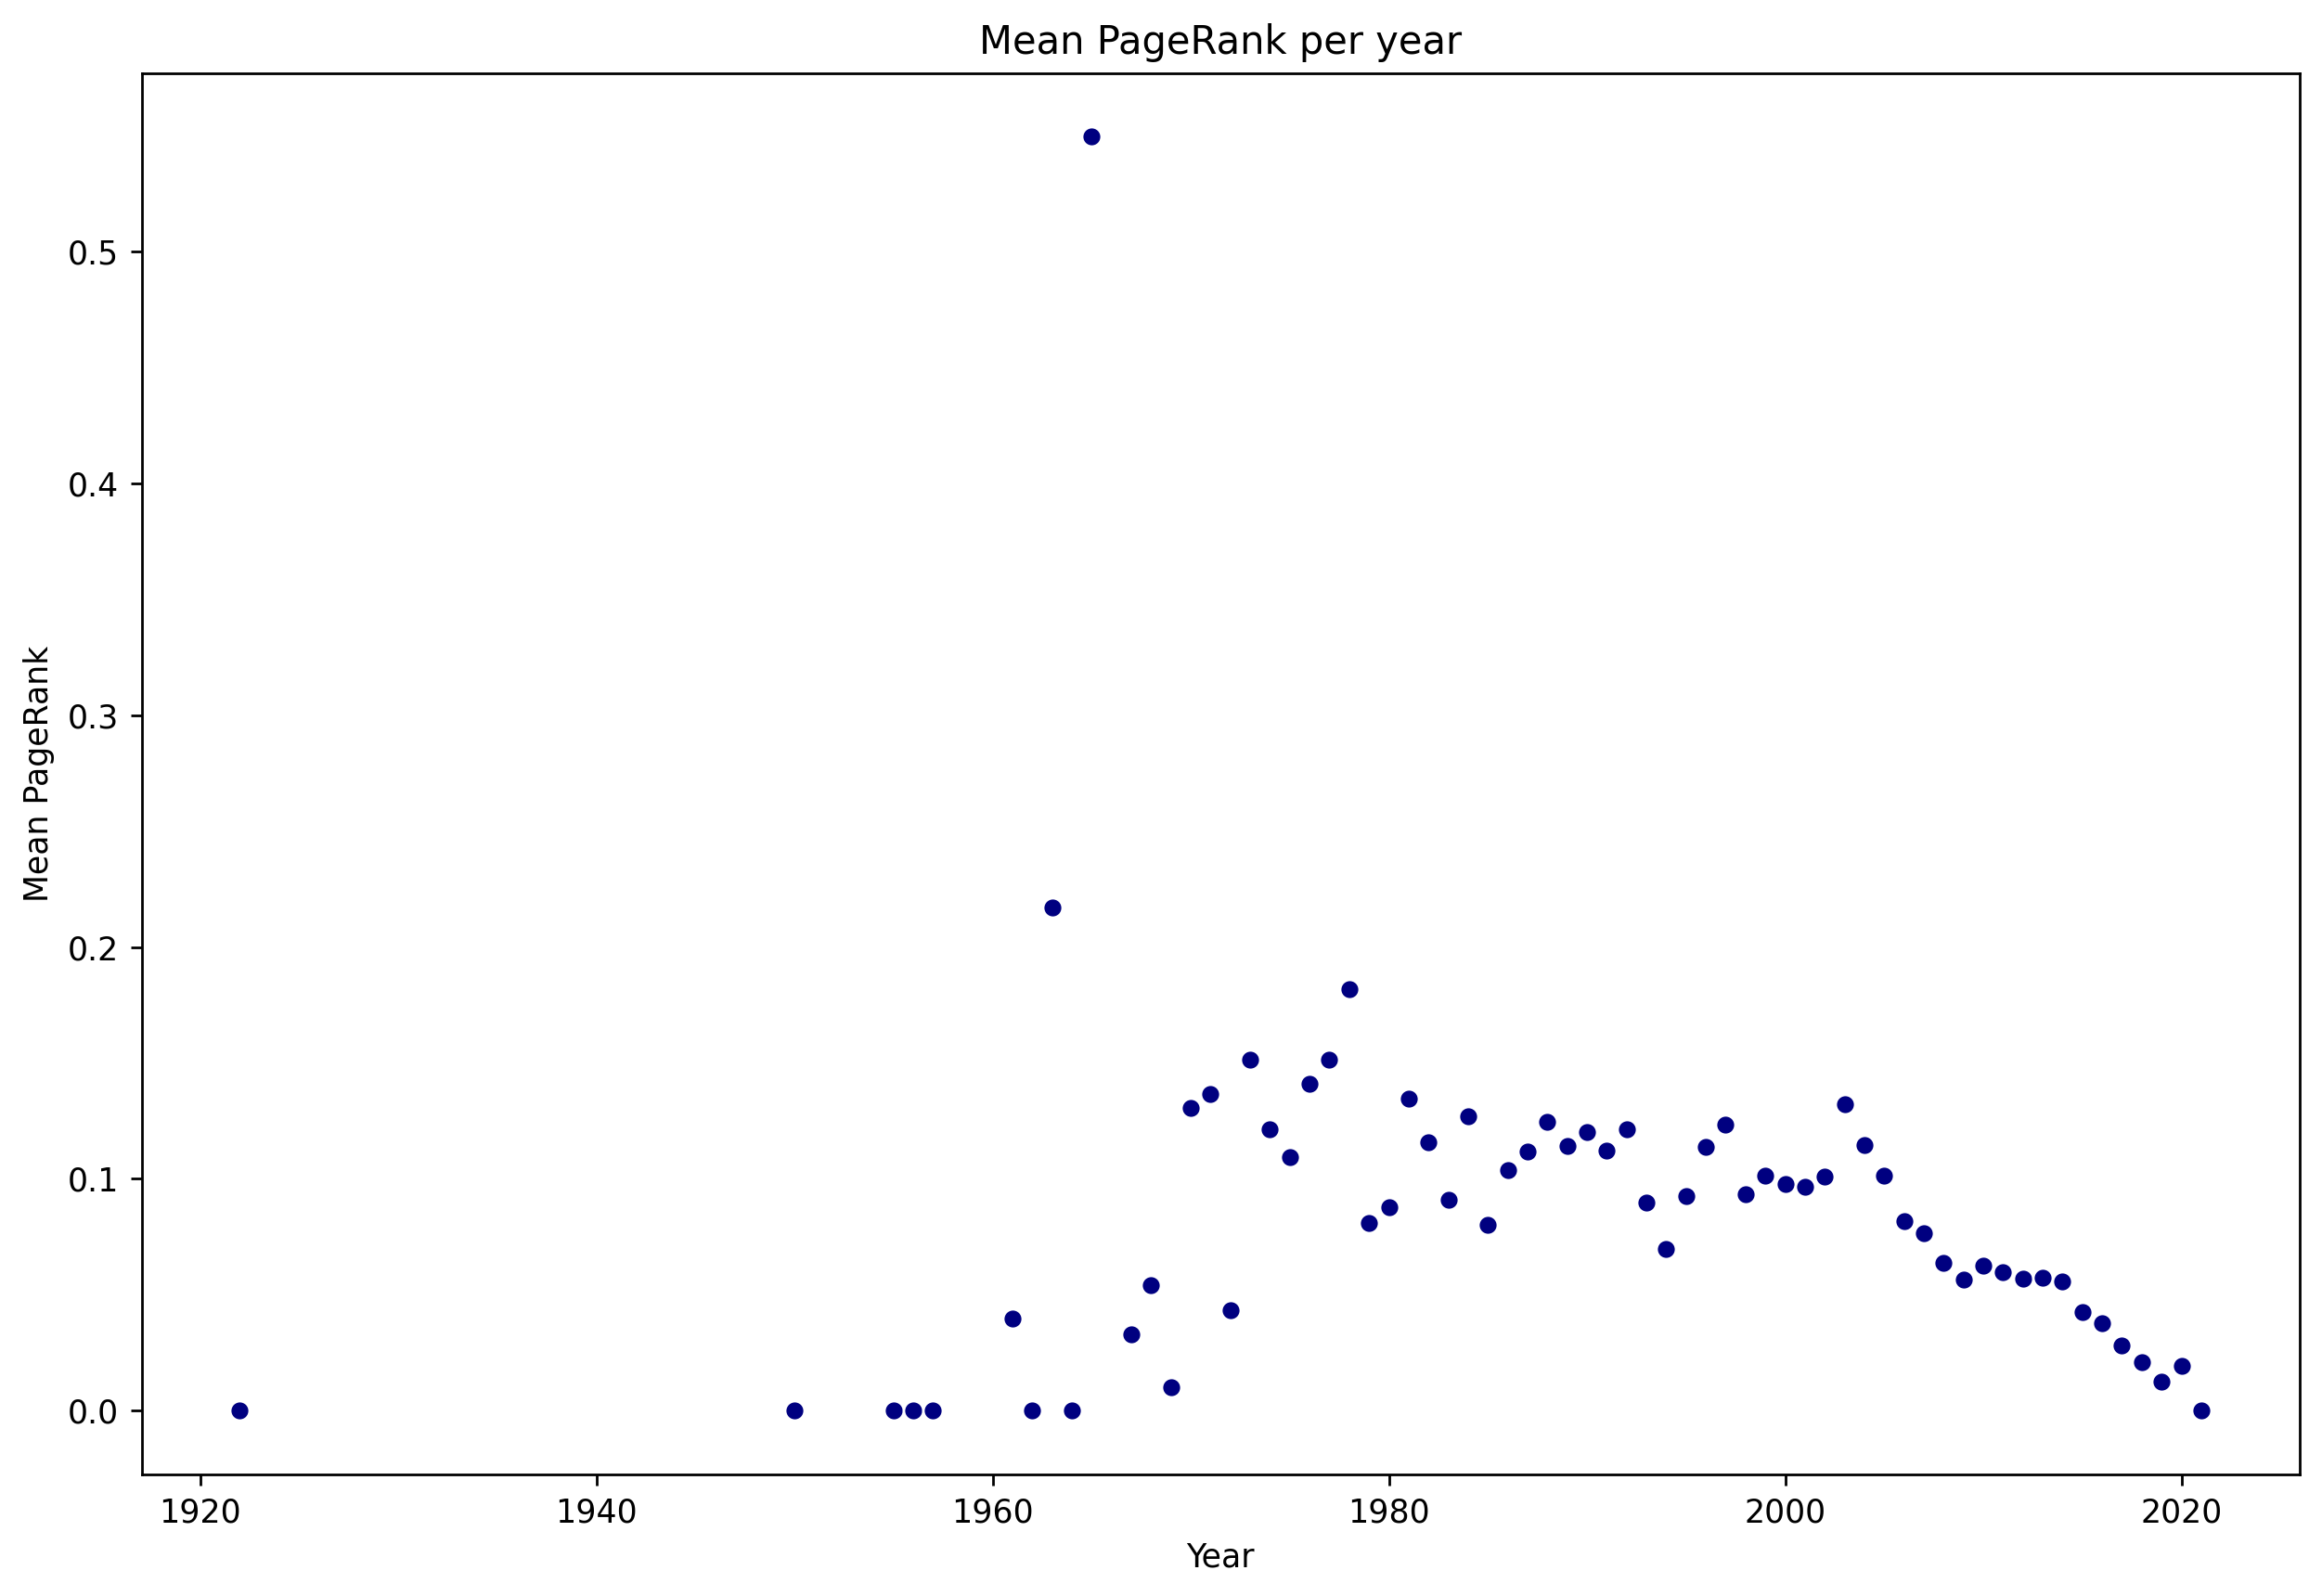

In [ ]:
pagerank_per_year = papers["pagerank"].groupby(papers["publish_time"].dt.year).mean()

fig = plt.figure(figsize=(12, 8), dpi=250)

ax = sns.scatterplot(x=pagerank_per_year.index.astype(int), y=pagerank_per_year, color=(0, 0, 0.5))
ax.set(
    title="Mean PageRank per year",
    xlabel="Year",
    ylabel="Mean PageRank",
)

plt.show()

There's a slight negative correlation between the mean PageRank and the publication year from the 1970s until today.

## Proposed Model

We propose a finetuning approach to predict static rankings of academic papers.
We stick to the static ranking prediction problem because of the semi supervised nature of it and the relevance it could have in the academic community.

### Dataset

A little bit more about the CORD-19 dataset.

### Framework

The problem is framed as a semi supervised one since the only model supervision we'll use is the static ranking of each paper, which can be computed solely based in the references graph of the dataset.
We use PageRank as the algorithm to compute the static ranking values and we expect to explore the impact on performance of using other static rankings algorithms.

Building the references graph is not a trivial task.
In our experiments, we built a graph edge from $A$ to $B$, i.e. a reference exists from paper $A$ to paper $B$, if and only if there exists a reference in paper $A$ that exactly matches the title of $B$.
We expect to explore the impact on performance of using less strict rules for building the references graph, since our current approach doesn't tolerate slight differences in paper titles, such as dots or semicolons.

After the previous process, we end up with a directed graph $G = (E, V)$ where each vertex is a paper and each edge $(A, B)$ is a reference from paper $A$ to paper $B$.
Then, we compute the PageRank values of each paper based on the structure of graph $G$.

We apply a series of transformations to those values to make it easier for the proposed model to learn the task.
Particularly, we apply $PageRank = MinMaxScaler(StandardizeScaler(Log(PageRank)))$.
These transformed values have a series of properties, such as being in the range $(0, 1)$ with a less skewed distribution than the original values, that are better for backpropagation.
We'll use these transformed ranking values as the semi-supervised labels of our model.

To predict these values we'll leverage recent advances in natural language processing using a pre--trained BERT--based model.
On top of the pre--trained language model we'll add a classifier head with output dimensionality equal to 2.
The output values are passed through a $Softmax$ activation function and we extract the second value as the predicted paper PageRank value.

In training we use a mean squared error loss between the predicted and target ranking scores to adjust the model's weight.
The dataset is split randomly to build the training, validation and test splits, with a proportion of 70%, 10%, and 20% of the entire dataset, respectively.
Finally, the model is trained with batches of size 16 and using backpropagation with the AdamW optimizer.

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from pytorch_lightning import Trainer
from pytorch_lightning.core.lightning import LightningModule

from transformers import AutoModelForSequenceClassification, AutoTokenizer, AdamW


class PapersDataset(Dataset):
    def __init__(self, df):
        self._df = df
    
    def __getitem__(self, idx):
        item = self._df.iloc[idx]
        text = item["title"] + " " + item["abstract"]
        pagerank = item["pagerank"]
        return {
            "text": text,
            "pagerank": torch.tensor(pagerank, dtype=torch.float)
        }
    
    def __len__(self):
        return len(self._df)
        
        
class RankingPredictor(LightningModule):
    def __init__(self, base_model, learning_rate=1e-5):
        super().__init__()
        
        self.language_model = AutoModelForSequenceClassification.from_pretrained(base_model)
        self.tokenizer = AutoTokenizer.from_pretrained(base_model)
        
        self.learning_rate = learning_rate
        
    
    def forward(self, papers):
        papers_encoded = self.tokenizer(
            papers,
            return_tensors="pt",
            padding=True,
            truncation=True
        )
        input_ids = papers_encoded["input_ids"].to(self.device)
        attention_mask = papers_encoded["attention_mask"].to(self.device)
        outputs = self.language_model(input_ids, attention_mask=attention_mask)[0]
        return outputs
    
    def configure_optimizers(self):
        optimizer = AdamW(model.parameters(), lr=self.learning_rate)
        return optimizer
    
    def loss(self, predicted, target):
        predicted_activated = F.softmax(predicted, dim=1)
        predicted_sliced = predicted_activated[:,1].squeeze()
        mse = F.mse_loss(predicted_sliced, target)
        return mse
    
    def _inference(self, batch, _):
        text = batch["text"]
        target = batch["pagerank"]
        
        predicted = self(text)
        loss = self.loss(predicted, target)
        
        return {
            "loss": loss,
        }
    
    def _epoch_end_metrics(self, outputs, prefix=""):
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        return avg_loss
    
    def training_step(self, batch, batch_idx):
        return self._inference(batch, batch_idx)
    
    def training_epoch_end(self, outputs):
        loss = self._epoch_end_metrics(outputs)
        return {"loss": loss, "log": { "loss":loss }}
    
    def validation_step(self, batch, batch_idx):
        return self._inference(batch, batch_idx)

    def validation_epoch_end(self, outputs):
        loss = self._epoch_end_metrics(outputs)
        return {"val_loss": loss, "log": { "val_loss":loss }}
    
    def test_step(self, batch, batch_idx):
        return self._inference(batch, batch_idx)

    def test_epoch_end(self, outputs):
        loss = self._epoch_end_metrics(outputs)
        return {"test_loss": loss, "log": { "test_loss":loss }}


In [ ]:
from sklearn.model_selection import train_test_split
from pytorch_lightning.loggers import WandbLogger

# Training: 70%; Validation: 10%; Test: 20%
train_df, test_df = train_test_split(papers, train_size=0.8, test_size=0.2, random_state=2827)
train_df, val_df = train_test_split(train_df, train_size=0.875, test_size=0.125, random_state=2827)

train_ds = PapersDataset(train_df)
val_ds = PapersDataset(val_df)
test_ds = PapersDataset(test_df)

BATCH_SIZE = 16

train_dl = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
val_dl = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
)
test_dl = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

model = RankingPredictor("bert-base-uncased")

wandb_logger = WandbLogger(
    name="N/A",
    project="ranking-inference"
)

trainer = Trainer(
    gpus=1,
    fast_dev_run=True,
    logger=wandb_logger,
    print_nan_grads=True,
    default_root_dir="/drive/My Drive/RISOTTO/weights"
)
trainer.fit(model, train_dataloader=train_dl, val_dataloaders=val_dl)
trainer.test(test_dataloaders=test_dl)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Running in fast_dev_run mode: will run a full train, val and test loop using a single batch
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]



  | Name           | Type                          | Params
-----------------------------------------------------------------
0 | language_model | BertForSequenceClassification | 109 M 
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


--------------------------------------------------------------------------------
TEST RESULTS
{'test_loss': tensor(0.2507, device='cuda:0')}
--------------------------------------------------------------------------------



{'test_loss': 0.25070032477378845}

## Evaluation

In [ ]:
CHECKPOINT_PATH = "/drive/My Drive/RISOTTO/weights/ranking-inference/34439om8/checkpoints/epoch=8.ckpt"

checkpoint = checkpoint = torch.load(CHECKPOINT_PATH)
model = RankingPredictor("bert-base-uncased")
model.load_state_dict(checkpoint["state_dict"])
model.to("cuda")
model.eval()
model

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

RankingPredictor(
  (language_model): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=7

In [ ]:
best_test_papers = test_df.sort_values(by="pagerank", ascending=False)
best_test_papers.head()

,cord_uid,pagerank,affiliation,country,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
53944,2eoff6nq,0.898167,"St Francis Medical Center, Wyckoff Heights Med...",USA,ef4165acd18952fb24b714cd1d048f216a3adf38,Elsevier; Medline; PMC,Severe Acute Respiratory Syndrome (SARS),10.1016/j.idc.2009.10.005,PMC7135483,2.01716e+07,no-cc,"This article reviews the virology, history, pa...",2010-02-18,"Cleri, Dennis J.; Ricketti, Anthony J.; Vernal...",Infect Dis Clin North Am,N/A,N/A,N/A,document_parses/pdf_json/ef4165acd18952fb24b71...,document_parses/pmc_json/PMC7135483.xml.json,https://doi.org/10.1016/j.idc.2009.10.005; htt...,770743
7277,whq1mhjy,0.807262,N/A,N/A,15323d4aeaed14fe20110797538397a66d89a8ba,PMC,Angiotensin-converting enzyme 2 is a functiona...,10.1038/nature02145,PMC7095016,1.46474e+07,no-cc,"Spike (S) proteins of coronaviruses, including...",2003-01-01,"Li, Wenhui; Moore, Michael J.; Vasilieva, Nata...",Nature,N/A,N/A,N/A,document_parses/pdf_json/15323d4aeaed14fe20110...,document_parses/pmc_json/PMC7095016.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,N/A
41150,d599uera,0.779435,Singapore General Hospital (Government Virus U...,"Netherlands;, China, France, UK, Germany",7b5d4d14d76305751a70e0740b86b905bb0df64a,Elsevier; PMC,Newly discovered coronavirus as the primary ca...,10.1016/s0140-6736(03)13967-0,PMC7112434,1.2893e+07,els-covid,Summary Background The worldwide outbreak of s...,2003-07-26,"Kuiken, Thijs; Fouchier, Ron AM; Schutten, Mar...",The Lancet,N/A,N/A,N/A,document_parses/pdf_json/7b5d4d14d76305751a70e...,document_parses/pmc_json/PMC7112434.xml.json,https://www.sciencedirect.com/science/article/...,1.13074e+07
60995,f31c4fwm,0.753431,N/A,N/A,fff6febdd287d474d7950b14faa899c4095557b3,Elsevier; PMC,Severe Acute Respiratory Syndrome,10.1378/chest.124.1.12,PMC7130151,1.28535e+07,els-covid,N/A,2003-07-31,"Hui, David S.C.; Sung, Joseph J.Y.",Chest,N/A,N/A,N/A,document_parses/pdf_json/fff6febdd287d474d7950...,document_parses/pmc_json/PMC7130151.xml.json,https://www.sciencedirect.com/science/article/...,8.06053e+06
41569,ky9j5al0,0.725050,Loyola University Medical Center,N/A,92d7c4b67c7792b1266cf0d47cc7ff852fa26bbc,Elsevier; PMC,Coronavirus Spike Proteins in Viral Entry and ...,10.1006/viro.2000.0757,PMC7133764,1.11628e+07,els-covid,N/A,2001-01-20,"Gallagher, Thomas M.; Buchmeier, Michael J.",Virology,N/A,N/A,N/A,document_parses/pdf_json/92d7c4b67c7792b1266cf...,N/A,https://api.elsevier.com/content/article/pii/S...,3.30532e+07


In [ ]:
best_papers_df = best_test_papers.iloc[:10]
best_texts = (best_papers_df["title"] + " " + best_papers_df["abstract"]).tolist()
best_texts

['Severe Acute Respiratory Syndrome (SARS) This article reviews the virology, history, pathology, epidemiology, clinical presentations, complications, radiology, laboratory testing, diagnosis, treatment, and prevention of severe respiratory distress syndrome, with reference to documented outbreaks of the disease.',
 'Angiotensin-converting enzyme 2 is a functional receptor for the SARS coronavirus Spike (S) proteins of coronaviruses, including the coronavirus that causes severe acute respiratory syndrome (SARS), associate with cellular receptors to mediate infection of their target cells(1,2). Here we identify a metallopeptidase, angiotensin-converting enzyme 2 (ACE2)(3,4), isolated from SARS coronavirus (SARS-CoV)-permissive Vero E6 cells, that efficiently binds the S1 domain of the SARS-CoV S protein. We found that a soluble form of ACE2, but not of the related enzyme ACE1, blocked association of the S1 domain with Vero E6 cells. 293T cells transfected with ACE2, but not those transf

In [ ]:
with torch.no_grad():
    best_inferences = model(best_texts).softmax(dim=1)[:,1]
best_inferences

tensor([0.1798, 0.4713, 0.7720, 0.2741, 0.0303, 0.0414, 0.3124, 0.5100, 0.3300,
        0.3762])

In [ ]:
best_papers_df.iloc[:10]["pagerank"]

53944    0.898167
7277     0.807262
41150    0.779435
60995    0.753431
41569    0.725050
17170    0.722244
11202    0.677401
60096    0.666779
44250    0.664866
54258    0.662664
Name: pagerank, dtype: float64

In [ ]:
worse_papers_df = best_test_papers.iloc[-10:]
worse_texts = (worse_papers_df["title"] + " " + worse_papers_df["abstract"]).tolist()
worse_texts

['Screening for Gastric Cancer in Japan Gastric endoscopy has not yet been recommended for organized or population-based cancer screening because at the moment, the sole criterion for evaluating the effectiveness of cancer screening is the reduction in the death rate, and not the mere detection of cancer. Nevertheless, compared with X-ray screening, which has normally been recommended, endoscopic screening is better at finding small lesions, at finding cancer at its earlier stages, making it more easily and economically treatable, and allows on-the-spot biopsies. Opportunistic, individually initiated screening by endoscopy is more and more in demand. Therefore, its excellent efficacy needs to be matched by improved toleration, improved safety, and improved manpower efficiency so that it can be standardized and utilized to its full diagnostic, therapeutic, and quality-of-life potential.',
 'Spatial Components in Disease Modelling Modelling of infectious diseases could help gain further 

In [ ]:
with torch.no_grad():
    worse_inferences = model(worse_texts).softmax(dim=1)[:,1]
worse_inferences

tensor([0.0334, 0.0900, 0.0042, 0.0502, 0.0606, 0.0543, 0.0158, 0.0037, 0.0060,
        0.0270])

In [ ]:
worse_papers_df.iloc[:10]["pagerank"]

14055    0.0
15841    0.0
10229    0.0
29173    0.0
35645    0.0
13951    0.0
26875    0.0
38799    0.0
43677    0.0
34131    0.0
Name: pagerank, dtype: float64

In [ ]:
from tqdm import tqdm_notebook as tqdm

target = []
predicted = []

for batch in tqdm(test_dl):
    batch_target = batch["pagerank"]
    batch_text = batch["text"]
    with torch.no_grad():
        batch_predicted = model(batch_text)
    target += batch_target.tolist()
    predicted += batch_predicted.softmax(dim=1)[:,1].tolist()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [ ]:
len(target), len(predicted)

(12486, 12486)

In [ ]:
zipped = np.array(sorted(zip(target, predicted), key=lambda el: el[0]))
zipped[:10]

array([[0.        , 0.01148298],
       [0.        , 0.02250096],
       [0.        , 0.00487366],
       [0.        , 0.00934911],
       [0.        , 0.00550291],
       [0.        , 0.00875001],
       [0.        , 0.08159216],
       [0.        , 0.00384312],
       [0.        , 0.00420982],
       [0.        , 0.00408449]])

In [ ]:
X, Y = zipped[:,0], zipped[:,1]

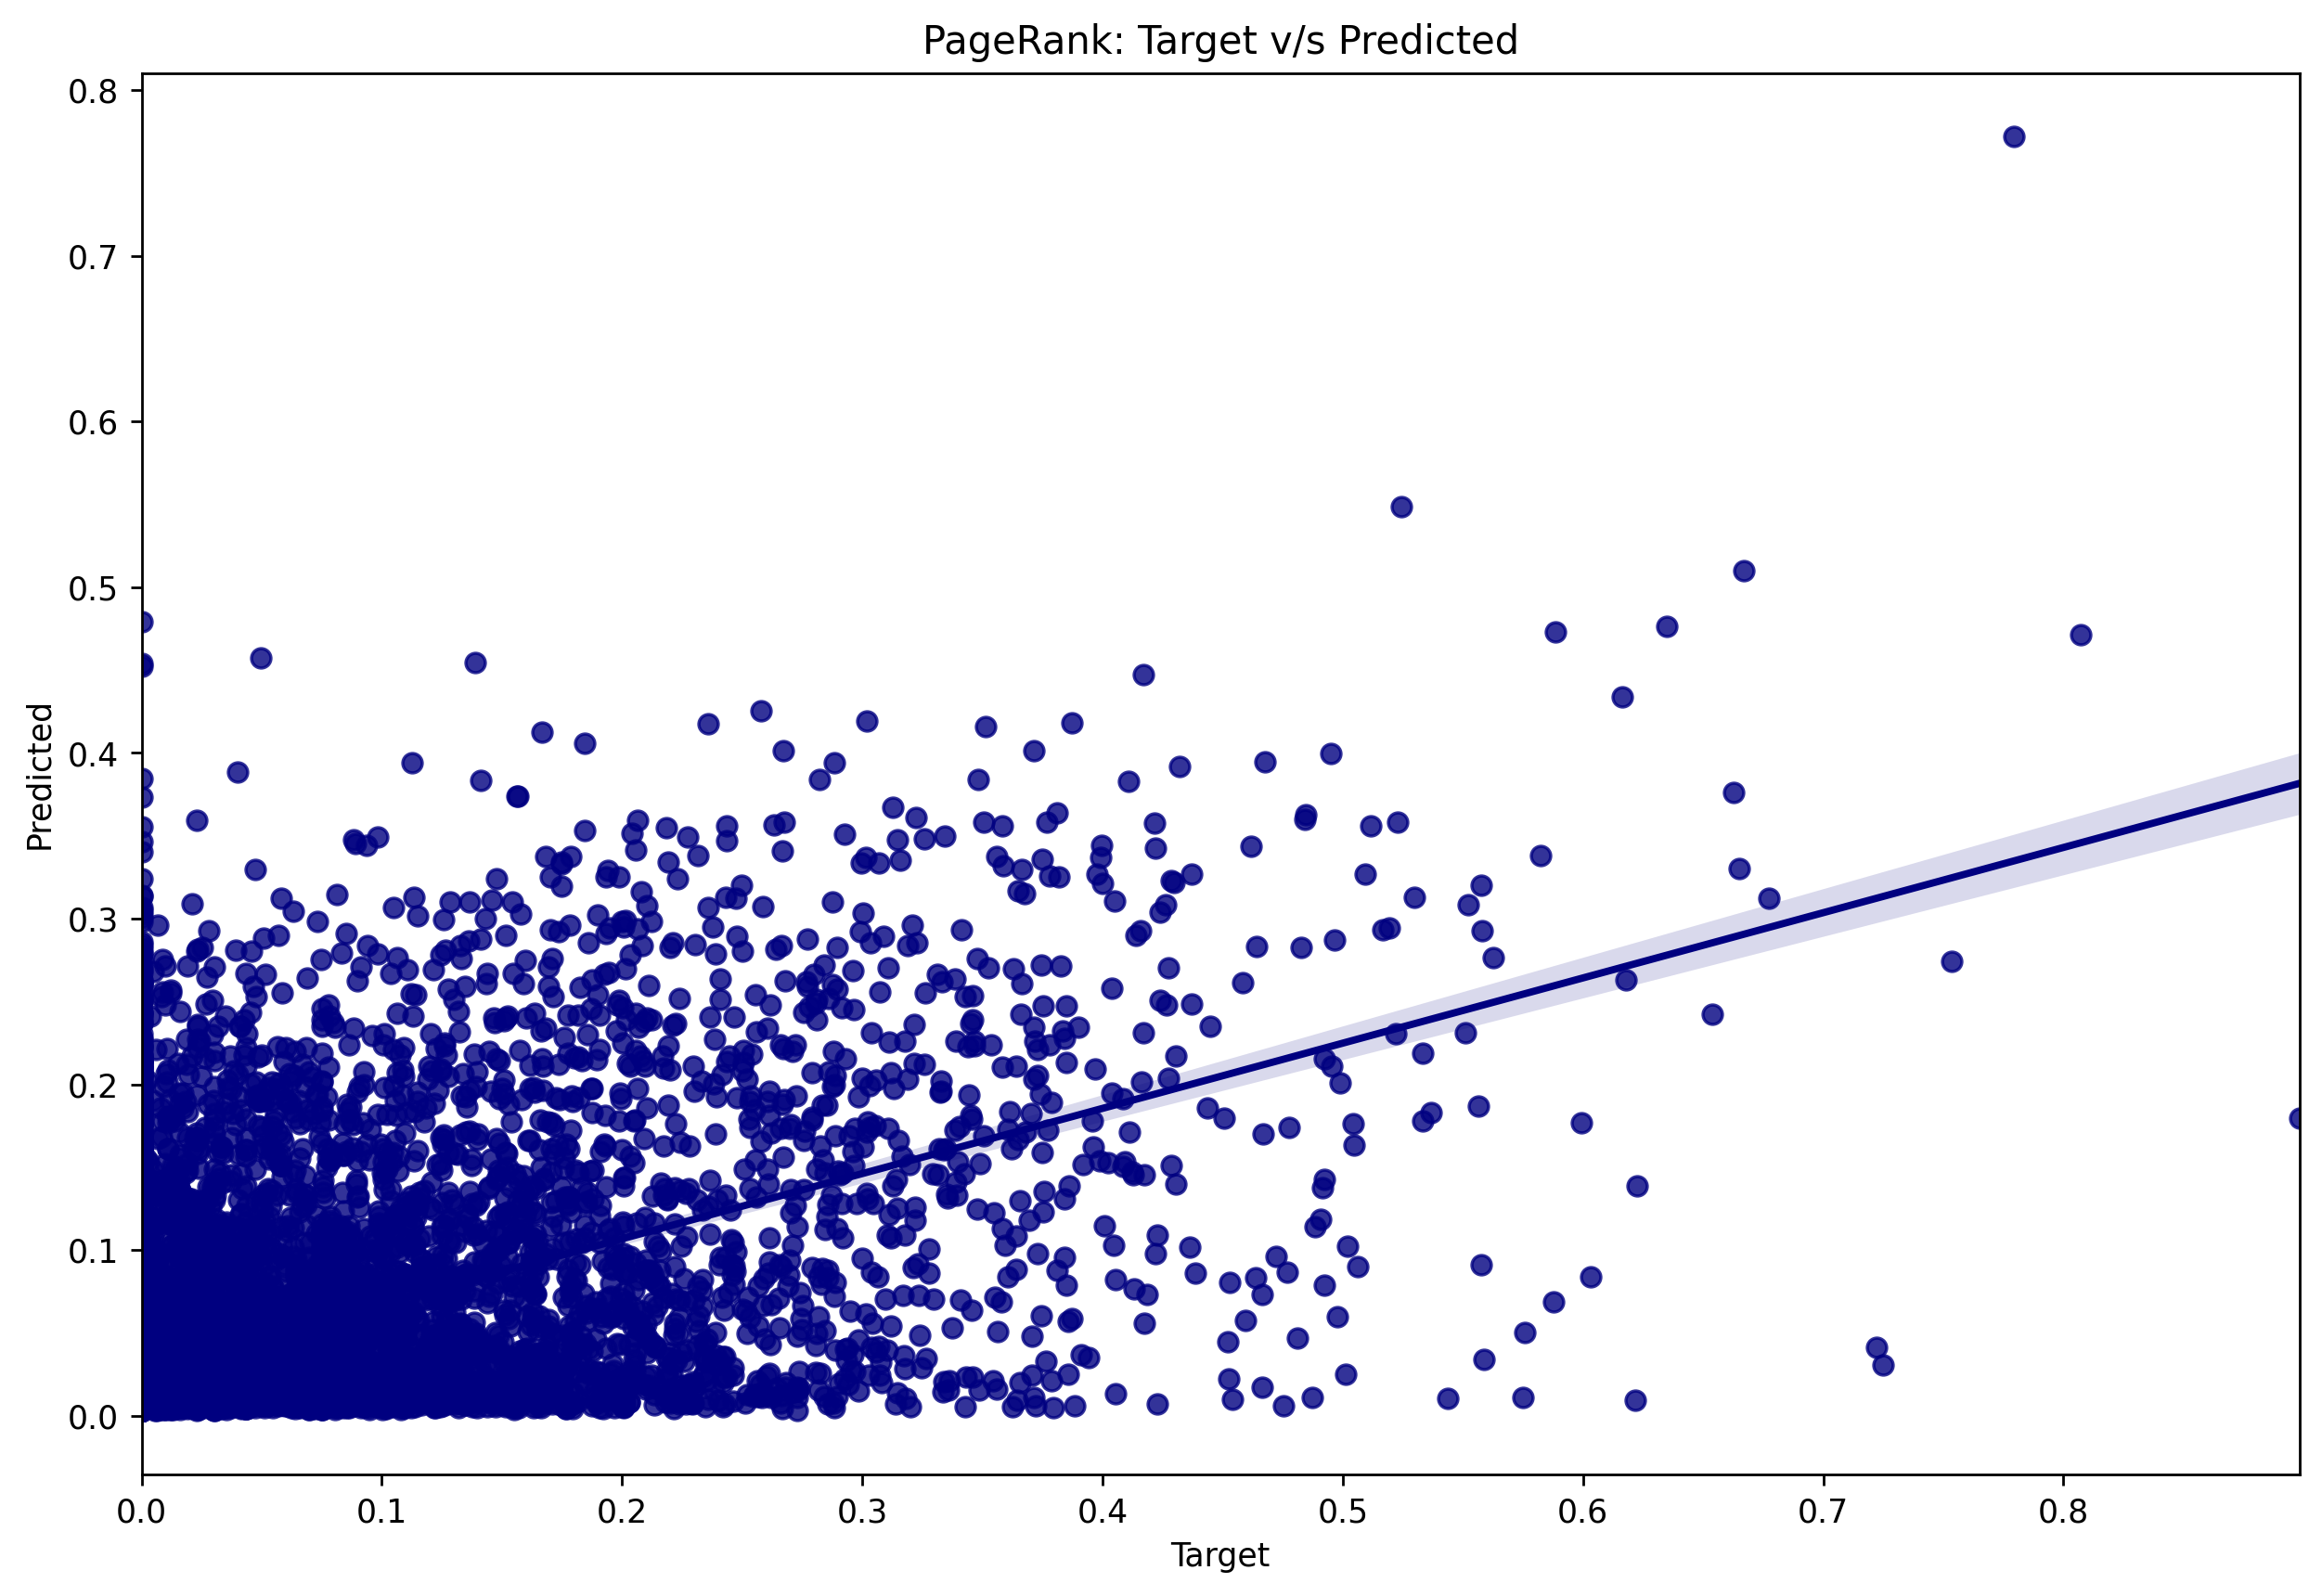

In [ ]:
fig = plt.figure(figsize=(12, 8), dpi=250)

ax = sns.regplot(
    x=X,
    y=Y,
    color=(0, 0, 0.5)
)
ax.set(
    title="PageRank: Target v/s Predicted",
    xlabel="Target",
    ylabel="Predicted",
)

plt.show()